In [18]:
# gen libs
import xarray as xr
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import time

# libs for poincaré
from osa import Client

# emc3 submodule
import xemc3

#vtk libs
from tvtk.api import tvtk
from mayavi.scripts import mayavi2
from PyQt5 import QtCore
import sip
import vtk
from mayavi import mlab
%gui qt

# importing widget libs to make interactive plots
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import os
import sys

In [3]:
#import the necessary functions from the previous scripts
loc_path_interpol_script = r"C:\Users\joag\Documents\Notebooks\W7X_intership"
fps = []
fps.append(loc_path_interpol_script + r"\make_parammesh_vtk.py")
fps.append(loc_path_interpol_script + r"\grid.py")
for path in fps:
    module_path = os.path.abspath(os.path.join(path))
    if module_path not in sys.path:
        sys.path.append(module_path)

In [4]:
from make_parammesh_vtk import make_parammesh_vtk
from grid import grid

In [5]:
grid?
# vtk.vtkStructuredGrid?

In [6]:
folder = r"C:\Users\joag\Documents\Notebooks"
path_timeseriesdata_emc3 = folder  + r"\N01.nc"
path_timeseriesdata_emc3
ds_tot = xr.open_dataset(path_timeseriesdata_emc3)

In [7]:
ds_tsdata_emc3 = ds_tot.isel(time = slice(-20,None))
ds_tsdata_emc3

<xarray.Dataset>
Dimensions:                       (delta_phi: 2, delta_r: 2, delta_theta: 2, phi: 36, r: 139, theta: 512, time: 20)
Coordinates:
    R_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    z_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    phi_bounds                    (phi, delta_phi) float64 ...
Dimensions without coordinates: delta_phi, delta_r, delta_theta, phi, r, theta, time
Data variables: (12/34)
    _plasma_map                   (r, theta, phi) int64 ...
    ne                            (time, r, theta, phi) float64 ...
    nZ1                           (time, r, theta, phi) float64 ...
    nZ2                           (time, r, theta, phi) float64 ...
    nZ3                           (time, r, theta, phi) float64 ...
    nZ4                           (time, r, theta, phi) float64 ...
    ...                            ...
    IMPURITY_IONIZATION_SOURCE_0  (time, r, theta, phi) float64 ...
    IMPURITY_IONIZATION_SOURCE_1  (time, r, theta, phi) float64 ...
    IMPURITY_NEUTRAL_0            (time, r, theta, phi) float64 ...
    IMP_RADIATION_0               (time, r, theta, phi) float64 ...
    FLUX_CONSERVATION_0           (r, theta, phi) float64 ...
    LG_CELL_0                     (r, theta, phi) float64 ...

In [8]:
mean_sel = ds_tsdata_emc3.mean(dim = 'time')
std_sel = ds_tsdata_emc3.std(dim = 'time')
std_tot = ds_tsdata_emc3.std()

C:\Users\joag\AppData\Local\Continuum\anaconda3\envs\Mayavi\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\joag\AppData\Local\Continuum\anaconda3\envs\Mayavi\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\joag\AppData\Local\Continuum\anaconda3\envs\Mayavi\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [9]:
np.where(np.isnan(std_sel.Te)==False)[0].shape

(1977076,)

In [10]:
"ir, it, ip tuples representing from to values"
def plot_noise_param(ds, dsparam, mean_dsparam, ir, it, ip):
    dsparam = np.array(dsparam)
    mean_dsparam = np.array(mean_dsparam)
    T = ds.Te.shape[0]
    reg_shape = (T, ir[1]-ir[0], it[1]-it[0], ip[1]-ip[0])
    t = np.array(np.linspace(0,T-1,T), dtype=np.int64)
    plt.figure()
    for i in range(reg_shape[1]):
        for j in range(reg_shape[2]):
            for k in range(reg_shape[3]):
                plt.plot(t, dsparam[:, ir[0]+i,it[0]+j,ip[0]+k] - mean_dsparam[ir[0]+i,it[0]+j,ip[0]+k])
                plt.xlabel("$t$")
                plt.ylabel("$\\theta_t - \\langle \\theta(t) \\rangle_t$")

In [13]:
from ipywidgets import interact
import ipywidgets as widgets
def sliderplot_noise(ir, it, ip):
    plot_noise_param(ds = ds_tsdata_emc3, 
                     dsparam = ds_tsdata_emc3.Te, 
                     mean_dsparam = mean_sel.Te, 
                     ir = ir, it = it, ip = ip)
rslider = widgets.IntRangeSlider(min = 0, max = mean_sel.Te.shape[0]-1, value = [130,138], description = 'R')
thetaslider = widgets.IntRangeSlider(min = 0, max = mean_sel.Te.shape[1]-1, value = [0,5], description = 'theta')
phislider = widgets.IntRangeSlider(min = 0, max = mean_sel.Te.shape[2]-1, value = [0,5], description = 'phi')
interact(sliderplot_noise, ir = rslider, it = thetaslider, ip = phislider)

interactive(children=(IntRangeSlider(value=(130, 138), description='R', max=138), IntRangeSlider(value=(0, 5),…

<function __main__.sliderplot_noise(ir, it, ip)>

In [14]:
ds_tsdata_emc3.R_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")).shape

(139, 512, 36)

In [15]:
grid_meanmean_sel = grid(ds = mean_sel, inc_r = [20, 138], inc_t = [0, 512], inc_p = [0, 4])
dimsg = grid_meanmean_sel.tor_x.shape[::-1]
sg_meanmean = tvtk.StructuredGrid(dimensions = dimsg)
sg_meanmean.points = grid_meanmean_sel.torflat
sg_meanmean.point_data.scalars = np.asarray(mean_sel.Te)[20:138,0:512,0:4].flatten()
sg_meanmean.point_data.scalars.name = "Te"

In [16]:
"""
Plotting the actual values in the W7X grid with the electron temperature as a test.
"""
# clear the field
mlab.clf()
#add the dataset to the pipeline, the principle is to add several object on top of each other
src_emc3 = mlab.pipeline.add_dataset(sg_meanmean)
# make a cut object to cut the 3D volum in slices in a user defined direction
cut_emc3 = mlab.pipeline.scalar_cut_plane(src_emc3)
# make a contour plot of the scalar field
cont_emc3 = mlab.pipeline.iso_surface(cut_emc3)
# add the outline of the 3d domain
mlab.outline()
# add axis to the plot
mlab.axes()

In [19]:
std_sel
# std_tot

<xarray.Dataset>
Dimensions:                       (delta_phi: 2, delta_r: 2, delta_theta: 2, phi: 36, r: 139, theta: 512)
Coordinates:
    R_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    z_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    phi_bounds                    (phi, delta_phi) float64 0.0 ... 0.6283
Dimensions without coordinates: delta_phi, delta_r, delta_theta, phi, r, theta
Data variables: (12/34)
    _plasma_map                   (r, theta, phi) float64 0.0 0.0 ... 0.0 0.0
    ne                            (r, theta, phi) float64 nan nan ... nan nan
    nZ1                           (r, theta, phi) float64 nan nan ... nan nan
    nZ2                           (r, theta, phi) float64 nan nan ... nan nan
    nZ3                           (r, theta, phi) float64 nan nan ... nan nan
    nZ4                           (r, theta, phi) float64 nan nan ... nan nan
    ...                            ...
    IMPURITY_IONIZATION_SOURCE_0  (r, theta, phi) float64 nan nan ... nan nan
    IMPURITY_IONIZATION_SOURCE_1  (r, theta, phi) float64 nan nan ... nan nan
    IMPURITY_NEUTRAL_0            (r, theta, phi) float64 nan nan ... nan nan
    IMP_RADIATION_0               (r, theta, phi) float64 nan nan ... nan nan
    FLUX_CONSERVATION_0           (r, theta, phi) float64 nan nan ... nan nan
    LG_CELL_0                     (r, theta, phi) float64 nan nan ... nan nan

In [20]:
cl = Client("http://esb.ipp-hgw.mpg.de:8280/services/w7xfp?wsdl")

In [21]:
# should be 21
cl.service.getProfilesNumberOfKnots()

21

In [23]:
tracer = Client('http://esb.ipp-hgw.mpg.de:8280/services/FieldLineProxy?wsdl')

''' set the start points (R, phi, Z) for the tracing... '''
p = tracer.types.Points3D()
p.x1 = np.linspace(5.64, 6.3, 30)
p.x2 = np.zeros(30)
p.x3 = np.zeros(30)

''' set a coil coilconfiguration ... '''
coilconfig = tracer.types.MagneticConfig()

''' e.g. using a coilconfig ID from CoilsDB: 
    1 : 'w7x standard case', 3 : 'low iota', 4 : 'high iota', 5 : 'low mirror', etc. '''
coilconfig.configIds = [0] 

''' you could also create your own coil coilconfigurations 
    e.g. use only all type 3 of the non-planar sc coils from w7x: '''
#coilconfig.coilsIds = [162, 167, 172, 177, 182, 187, 192, 197, 202, 207]
#coilconfig.coilsIdsCurrents = [9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92]

''' you can use a grid for speeding up your requests. 
    Without a grid all tracing steps will be calculated by using Biot-Savart 
'''
my_grid = tracer.types.CylindricalGrid()
my_grid.RMin = 4.05
my_grid.RMax = 6.75
my_grid.ZMin = -1.35
my_grid.ZMax = 1.35
my_grid.numR = 181
my_grid.numZ = 181
my_grid.numPhi = 481

g = tracer.types.Grid()
g.cylindrical = my_grid
g.fieldSymmetry = 5

coilconfig.grid = g


pctask = tracer.types.PoincareInPhiPlane()
pctask.numPoints = 300
pctask.phi0 = [0.0]
                     
task = tracer.types.Task()
task.step = 0.01
task.poincare = pctask

''' you can use a Machine object for a limitation of the tracing region. 
    This sample uses a torus model (id = 164) from ComponentsDB: '''
machine = tracer.types.Machine()
machine.meshedModelsIds = [164] 
machine_grid = tracer.types.CartesianGrid()
machine_grid.XMin = -7
machine_grid.XMax = 7
machine_grid.YMin = -7
machine_grid.YMax = 7
machine_grid.ZMin = -1.5
machine_grid.ZMax = 1.5
machine_grid.numX = 400
machine_grid.numY = 400
machine_grid.numZ = 100

machine.grid = machine_grid
# machine = None

''' make a request to the web service: '''
result = tracer.service.trace(p, coilconfig, task, machine, None)

In [24]:
"""
Y-slices of raw data.
"""
# %matplotlib
ds_sel_Te = ds_tsdata_emc3.Te[:,20:138,0:512,:]
def plot_emc3toroidal(itime, ip):
    figemc3 = plt.figure(figsize=(15,15))
    axemc3 = figemc3.add_subplot()
    clev = np.arange(ds_sel_Te[itime,:,:,ip].min(),
                     ds_sel_Te[itime,:,:,ip].max(),.5)
    cemc3 = axemc3.contourf(grid_meanmean_sel.R[:,:,ip], 
                            grid_meanmean_sel.tor_z[:,:,ip], 
                            ds_sel_Te[itime,:,:,ip], 
                            clev)
    figemc3.colorbar(cemc3)
    
    # Poincaré
    for i in range(0,len(result.surfs)):
        axemc3.scatter(result.surfs[i].points.x1, result.surfs[i].points.x3, s=0.1)
    
phislider = widgets.IntSlider(min = 0, max = 3, value = 0)
timeslider = widgets.IntSlider(min = 0, max = 19, value = 0)
interact(plot_emc3toroidal, itime = timeslider, ip = phislider)

interactive(children=(IntSlider(value=0, description='itime', max=19), IntSlider(value=0, description='ip', ma…

<function __main__.plot_emc3toroidal(itime, ip)>

In [25]:
"""
1. Define indices of edges near the x-point.
2. Inspect the noise of the Rz slices of these edges.
3. Do the interpolation on these region so that the data resembles image data.
4. Try different denoising techniques on the image data. For instance scikit wavelet denoising.
"""

def reduce_region_of_interest(ds, ds_param, region, iphi):
    """
    Args:
     - ds, xarray, time series dataset after slicing it into stationary solution
     - ds_param, xarray, instantenous(time index given) time series dataset of a selected parameter after slicing...
     - region, ndarray np.int64, indices in describing regional boundaries in r, theta, phi direction
    Out:
     - rcoord, zcoord, data_rzslice
     - dims = (n_region, direction, start/stop) = (2, 2) = (r/z, start/stop)
    """
    # dims = (time, r, theta, phi)
    rcoord = ds.emc3['R_corners'][region[0,0]:region[0,1], region[1,0]:region[1,1], iphi]
    zcoord = ds.emc3['z_corners'][region[0,0]:region[0,1], region[1,0]:region[1,1], iphi]
    data_rzslice = np.array(ds_param[region[0,0]:region[0,1], region[1,0]:region[1,1], iphi])
    return rcoord, zcoord, data_rzslice

In [26]:
"""
remember the grid has the dimensions (139,512,36) = (r, theta, phi)
only restrict in (r,theta)
"""

regstest = np.zeros((5, 2, 2), dtype = np.int64)
regstest[:,0,0] = 50
regstest[:,0,1] = 138
regstest[0,1,0] = 10
regstest[0,1,1] = 30
regstest[1,1,0] = 50
regstest[1,1,1] = 130
regstest[2,1,0] = 160
regstest[2,1,1] = 190
regstest[3,1,0] = 330
regstest[3,1,1] = 360
regstest[4,1,0] = 380
regstest[4,1,1] = 450

In [27]:
import warnings
warnings.simplefilter("ignore", UserWarning)

def plot_Te_zoomed(itime, ip, ireg):
    """
    Watch out for:
    MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
      c = plt.pcolormesh(R[:, :,ip],
    """
    rcoord, zcoord, data_rzslice = reduce_region_of_interest(ds = ds_tsdata_emc3,
                                                             ds_param = ds_tsdata_emc3.Te[itime],
                                                             region = regstest[ireg], iphi = ip)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot()
    c = plt.pcolormesh(rcoord, zcoord, data_rzslice, cmap = plt.cm.jet, shading = 'auto')
    plt.colorbar(c, label="$T_e$")
    plt.xlabel("$R[m]$")
    plt.ylabel("$z[m]$")
#     plt.legend()
phislider = widgets.IntSlider(min = 0, max = 35)
timeslider = widgets.IntSlider(min = 0, max = 19)
regionslider = widgets.IntSlider(min = 0, max = len(regstest)-1, value=1)
interact(plot_Te_zoomed, itime = timeslider, ip = phislider, ireg = regionslider)

interactive(children=(IntSlider(value=0, description='itime', max=19), IntSlider(value=0, description='ip', ma…

<function __main__.plot_Te_zoomed(itime, ip, ireg)>

In [30]:
gridlist_timeseries = []
sgridlist = []
i = 0
for region in regstest:
    print("region[0]", region[0], "region[1]", region[1])
    # use ngrid_cart = 128 to have dimensions of powers of 2
    gridlist_timeseries.append( grid(ds_tsdata_emc3, ngrid_cart=128, inc_r= region[0],inc_t=region[1], inc_p = [0,35] ) )
    sg = tvtk.StructuredGrid(dimensions = gridlist_timeseries[i].tor_x.shape[::-1])
    sg.points = gridlist_timeseries[i].torflat
    sgridlist.append(sg)    
    i+=1

region[0] [ 50 138] region[1] [10 30]
region[0] [ 50 138] region[1] [ 50 130]
region[0] [ 50 138] region[1] [160 190]
region[0] [ 50 138] region[1] [330 360]
region[0] [ 50 138] region[1] [380 450]


In [274]:
# paramlist = []
# for i in range(regstest.shape[0]):
#     print(i)
#     # setting the time index to 0
#     parammes_r, notfound = make_parammesh_vtk(grid_obj = gridlist_timeseries[i],
#                                               sgrid = sgridlist[i], 
#                                               param_torgrid = np.array(ds_tsdata_emc3.Te[0,regstest[i,0,0]:regstest[i,0,1],
#                                                                                          regstest[i,1,0]:regstest[i,1,1], :4]) )
#     print(len(notfound))
#     paramlist.append(parammes_r)

In [275]:
# ts_paramlist = [[]]*ds_tsdata_emc3.Te.shape[0]
# len(ts_paramlist)
# ts_paramlist[1]
# ts_paramlist[1].append([1])
# ts_paramlist[1].append([1])
# ts_paramlist[1]

In [31]:
"""
Time loop:
 - instead of doing the interpolation on all timerframes, store indices of points in the w7x grid and then
 calculate the interpolation just once
Looping over cartesian points:
 - parallelize the for loop
"""
def makeparamlist(ds_param, sgridlist, gridlist, regions):
    """
    Args:
     - ds_param, xarray np.float64, parameter dataset
     - sgridlist, tvtk.StructuredGrid object, the W7X grid
     - gridlist, grid object
     - regions, ndarray np.int64, indices of the regions of interest
    Out:
     - ts_paramlist, list of ndarray np.float64, times series meshgrid of parameter values (nt,) (ix, iy, iz)
    """
    ds_param = np.array(ds_param)
    ts_paramlist = []
    for t in range(ds_param.shape[0]):
        print(t)
        paramlist = []
        for i in range(regions.shape[0]):
            # the grids are time indep, only the parameter value varies with time
            parammesh_r, notfound = make_parammesh_vtk(grid_obj = gridlist[i],
                                                       sgrid = sgridlist[i],
                                                       param_torgrid = ds_param[t,regstest[i,0,0]:regstest[i,0,1],
                                                                                regstest[i,1,0]:regstest[i,1,1],:] )
            paramlist.append(parammesh_r)
        ts_paramlist.append(paramlist)
    return ts_paramlist

In [32]:
tik = time.time()
pmesh_ts = makeparamlist(ds_param = ds_tsdata_emc3.Te, 
                         sgridlist = sgridlist, 
                         gridlist = gridlist_timeseries, 
                         regions = regstest)
tok = time.time()

0


KeyboardInterrupt: 

In [ ]:
from save_interpolated_data import parammesh_timeseries_tofile, parammesh_timeseries_readfile

In [ ]:
# write the interpolated data to file
filename_pmesh_ts = 'parameter_meshgrid_time_series_data_128x128x128'
parammesh_timeseries_tofile(filename_pmesh_ts, pmesh_ts)

In [ ]:
# load the interpolated data from file
pmesh_ts_fromfile = parammesh_timeseries_readfile(filename_pmesh_ts, (len(pmesh_ts),len(pmesh_ts[0]),))

In [197]:
print("Runtime potmeshlist is ", tok-tik, "seconds for ngrid = ", gridlist_timeseries[0].cart_x.shape[0])
print(len(pmesh_ts))
print(len(pmesh_ts[0]))
pmesh_ts[0][0].shape

Runtime potmeshlist is  2451.563220977783 seconds for ngrid =  32
20
5


(32, 32, 32)

In [ ]:
with open('parametermesh_timeseries.txt', 'w') as f:
    for t in pmesh_ts:
        for region in t:
            f.write("%s\n" % region)

In [198]:
def plot_interpol_regs(itime, ireg, iy):
    plt.figure(figsize=(10,10))
    im = plt.imshow(pmesh_ts[itime][ireg].T[::-1][:,iy])
    plt.colorbar(im)
timeslider = widgets.IntSlider(min = 0, max = len(pmesh_ts)-1, value=0)
yslider = widgets.IntSlider(min = 0, max = pmesh_ts[0][0].T[::-1].shape[1]-2, value=1)
regionslider = widgets.IntSlider(min = 0, max = len(regstest)-1, value=1)
interact(plot_interpol_regs, itime = timeslider, ireg = regionslider, iy = yslider)

interactive(children=(IntSlider(value=0, description='itime', max=19), IntSlider(value=1, description='ireg', …

<function __main__.plot_interpol_regs(itime, ireg, iy)>

In [199]:
from skimage.restoration import denoise_wavelet, cycle_spin
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
import skimage.data

In [200]:
def shiftinv_wavelet_denoising(tsdata, int_y = [0,pmesh_ts[0][0].shape[1]]):
    """
    Args:
     - tsdata, list of ndarray np.float64 (nt,)(nr,)(ix, iy, iz), list of times of list of regions of parameter mesh
     - int_phi, list of int, defining the interval in phi direction
    Out:
    """
    tik = time.time()
    denoised = []
    for t in range(len(tsdata)):
        denoised_regions = []
        for r in range(len(tsdata[0])):
            img = tsdata[t][r].T[::-1,int_y[0]:int_y[1]].copy()
            imgisnan = np.isnan(img)
            img[imgisnan] = np.zeros(img[imgisnan].shape)
            # multichannel = bool, do you have rgb/csv/hsv etc?, convert2ycbcr = bool, req multichannel = True
            # denoise_kwargs = dict(multichannel=False, convert2ycbcr=False, wavelet='db1', rescale_sigma=True)
            denoised_reg = cycle_spin(img, func=denoise_wavelet, max_shifts=(4,4,4))#max_shifts=img.shape
            # set values that were nan before the denoising back to nan
            denoised_reg[imgisnan] = np.ones(denoised_reg[imgisnan].shape)*np.nan
            denoised_regions.append(denoised_reg)
        denoised.append(denoised_regions)
    tok = time.time()
    return denoised, tok-tik

In [201]:
emc3_denoised, runtime = shiftinv_wavelet_denoising(tsdata = pmesh_ts) 

In [202]:
emc3_denoised[1][4].shape

(32, 32, 32)

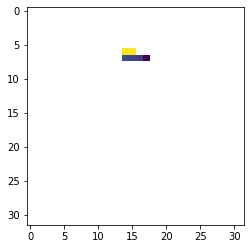

In [203]:
plt.imshow(emc3_denoised[0][1][:,30])

In [ ]:
def compare_regplot(ogimg, denoised_img):
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))
    noisy = ax[0,0].imshow(ogimg)
    ax[0,0].set_title("Noisy")
    fig.colorbar(noisy, ax = ax[0,0])
    denoised = ax[0,1].imshow(denoised_img)
    ax[0,1].set_title("Denoised")
    fig.colorbar(denoised, ax = ax[0,1])
    noise = ax[1,0].imshow(ogimg - denoised_img)
    ax[1,0].set_title("Noise")
    fig.colorbar(noise, ax = ax[1,0])

In [30]:
"""
As illustrated here, if there are NaN values in the data the shift-invariant wavelet denoising
method does not work and sets all the values of the resulting image to NaN.
"""

# fig, ax = plt.subplots(ncols = 3, figsize = (10,10))
# img = img_as_float(skimage.data.camera())
# sigma = 0.1
# img = img + sigma * np.random.standard_normal(img.shape)
# img[:200,100:300] = np.ones(img[:200,100:300].shape)*np.nan
# denoised = cycle_spin(img, func=denoise_wavelet, max_shifts=3)
# ax[0].imshow(img)
# ax[0].set_title("Noisy")
# ax[1].imshow(denoised)
# ax[1].set_title("Denoised")
# ax[2].imshow(img - denoised)
# ax[2].set_title("Noise")

'\nAs illustrated here, if there are NaN values in the data the shift-invariant wavelet denoising\nmethod does not work and sets all the values of the resulting image to NaN.\n'

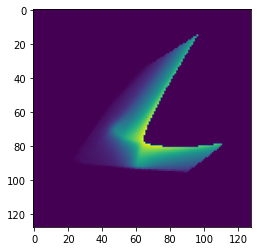

In [264]:
tik = time.time()
img0_reg = pmesh_ts[0][1].T[::-1][:,1:3].copy()
imgisnan = np.isnan(img0_reg)
img0_reg[imgisnan] = np.zeros(img0_reg[imgisnan].shape)
# plt.imshow(img0_reg[:,1])
# img0_reg[imgisnan] = np.ones(img0_reg[imgisnan].shape)*np.nan
plt.imshow(img0_reg[:,1])
# plt.imshow(paramlist[1].T[::-1][:,3])

In [265]:
np.where(imgisnan == True)[0].shape
img0_reg[:,0].shape

(128, 128)

In [266]:
# multichannel = bool, do you have rgb/csv/hsv etc?, convert2ycbcr = bool, req multichannel = True
# denoise_kwargs = dict(multichannel=False, convert2ycbcr=False, wavelet='db1', rescale_sigma=True)
denoised_reg = cycle_spin(img0_reg, func=denoise_wavelet, max_shifts=img0_reg.shape)
tok = time.time()

In [267]:
np.where(imgisnan == True)[0].shape
imgisnan.shape
np.where(np.isnan(denoised_reg) == True)[0].shape

(0,)

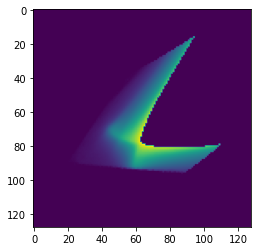

In [268]:
plt.imshow(denoised_reg[:,0])

In [269]:
# set values that were nan before the denoising back to nan
img0_reg[imgisnan] = np.ones(img0_reg[imgisnan].shape)*np.nan
denoised_reg[imgisnan] = np.ones(denoised_reg[imgisnan].shape)*np.nan

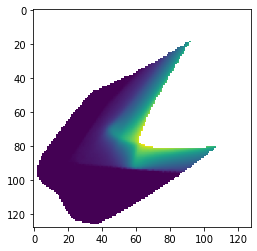

In [270]:
plt.imshow(denoised_reg[:,0])

2D shift-invariant denoising took  2414.8315229415894 seconds.


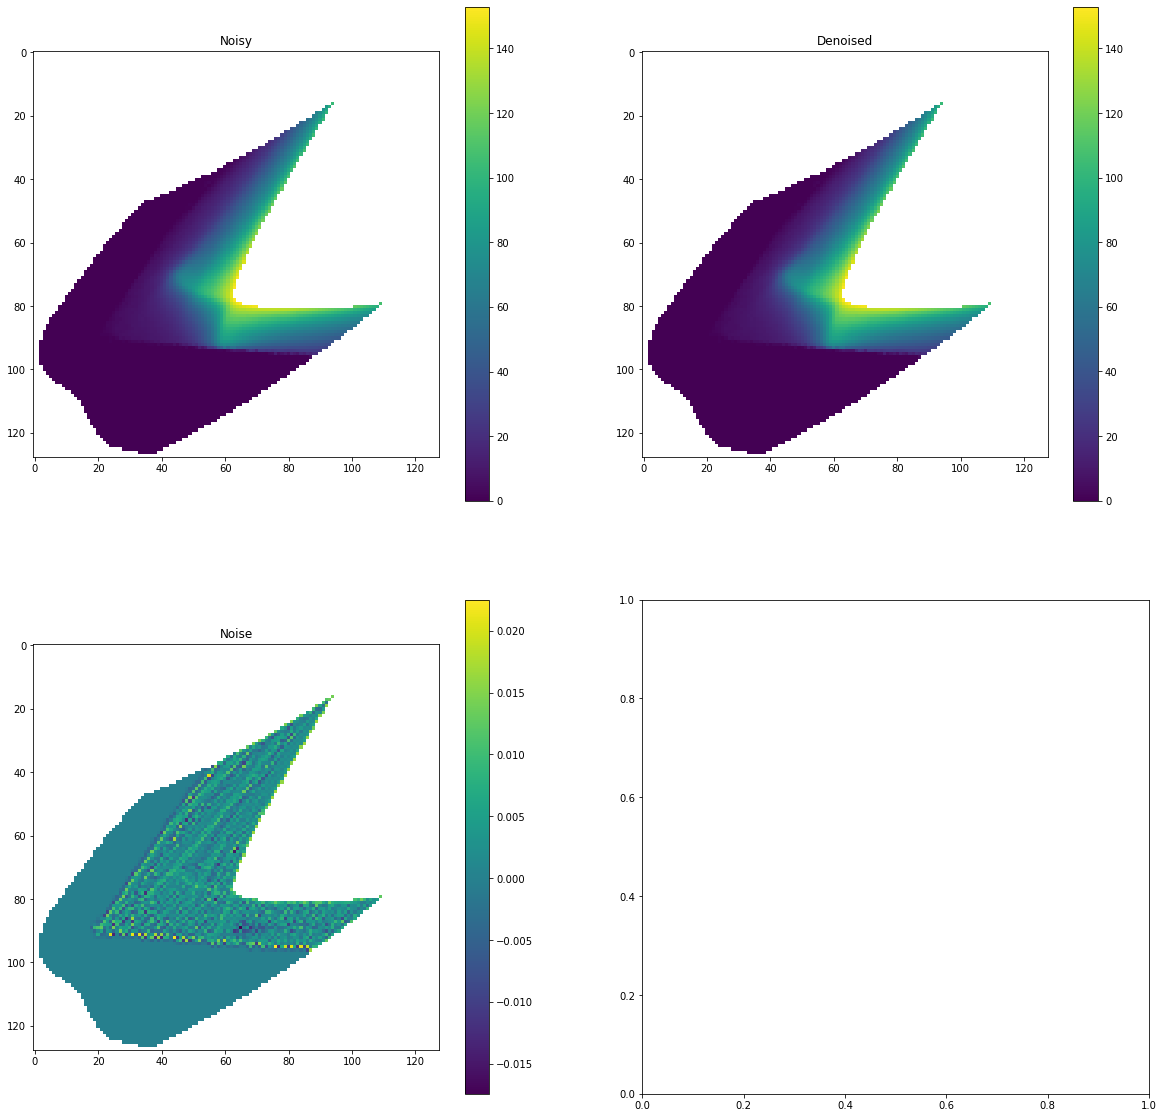

In [271]:
print("2D shift-invariant denoising took ", tok - tik, "seconds.")
compare_regplot(ogimg = img0_reg[:,0], denoised_img = denoised_reg[:,0] )
# compare_regplot(ogimg = img0_reg[:,1], denoised_img = denoised_reg[:,1])

# Conservation of physical quantities

1. Formulate the equations for the particle and flux balance.
2. Implement the conservation equations.
3. Confirm the interpolation is conservation preserving.
4. Quantify the error of conservation introduced by the interpolation?

# The effect of noise with regards to the conservation of physical quantites
1. Add independent noiseterms to each terms of the conservation equations and see how it affects the interpolated data.
2. Apply the filtering to mean data + known noise terms to quantify the effect of the filtering method.
3. Try and quantify when the conservation laws break down by increasing the noise contribution.
4. Quantize the effect of the filtering method wiht regards to the conservation laws. How much does the filtering method increase the threshold of the noise contribution with regards to the preservation of conservation laws.

# Decomposing the drift terms
1. Formulate the equations of the drift terms.
2. Split drift terms into divergence-free and non-divergence-free terms.
3. Analyze the magnitude of the divergence-free terms. Give relative contribution measures to the $\mathbf{E}\times\mathbf{B}$-terms.
4. Give an analysis on whether to implement a divergence-free optimized interpolation scheme or not. If yes, go to the last step.

# Implementing divergence-free property of interpolation scheme
1. Generate synthetic divergence free field.
2. Implement method for checking diverge-free property of the field.
3. Investigate the effect that noise contribution has to the divergence-free property of the field and apply the filtering method on the synthetic field to give a measure on how the filtering method improves the preservation of the divergence-free property.
4. By using the synthetic divergence-free field, implement a divergence-free interpolation method or optimize the already implemented method.
5. Apply the divergence free interpolation on the raw emc3 data and confirm the divergence-free property of the relevant terms.
6. Apply the filtering method and repeat step 5.
7. Quantize the effect of the filter by comparing to the mean of the time series data.
8. Do a bootstrap of the standard deviation to give a measure on the accuracy of the mean, and finally do a bias corrected estimate?

# Particle conservation

## Generalized particle conservation

\begin{equation}
    \nabla (n v) = S_p
\end{equation}

where the particle source term $S_p$ is set to zero because it will only be non-zero in proximity of the targets. $n$ and $v$ is the particle density and fluid velocity so the resulting conservation equation is:
\begin{equation}
\nabla(nv) = 0
\end{equation}

# Flux conservation

\begin{equation}
\Gamma = 
\end{equation}

In [207]:
# note M is the mach number of the parallell number
mean_sel

<xarray.Dataset>
Dimensions:                       (delta_phi: 2, delta_r: 2, delta_theta: 2, phi: 36, r: 139, theta: 512)
Coordinates:
    R_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    z_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    phi_bounds                    (phi, delta_phi) float64 0.0 ... 0.6283
Dimensions without coordinates: delta_phi, delta_r, delta_theta, phi, r, theta
Data variables: (12/34)
    _plasma_map                   (r, theta, phi) int64 379649 379649 ... 398090
    ne                            (r, theta, phi) float64 nan nan ... nan nan
    nZ1                           (r, theta, phi) float64 nan nan ... nan nan
    nZ2                           (r, theta, phi) float64 nan nan ... nan nan
    nZ3                           (r, theta, phi) float64 nan nan ... nan nan
    nZ4                           (r, theta, phi) float64 nan nan ... nan nan
    ...                            ...
    IMPURITY_IONIZATION_SOURCE_0  (r, theta, phi) float64 nan nan ... nan nan
    IMPURITY_IONIZATION_SOURCE_1  (r, theta, phi) float64 nan nan ... nan nan
    IMPURITY_NEUTRAL_0            (r, theta, phi) float64 nan nan ... nan nan
    IMP_RADIATION_0               (r, theta, phi) float64 nan nan ... nan nan
    FLUX_CONSERVATION_0           (r, theta, phi) float64 nan nan ... nan nan
    LG_CELL_0                     (r, theta, phi) float64 nan nan ... nan nan

In [216]:
# plt.figure(figsize=(20,20))
# mean_sel.emc3.plot_Rz('fort.46_0', phi = 0)
gridlist_timeseries

In [382]:
def get_magneticfield(grid_obj):
    """
    Args:
     - grid_obj, grid object
    Out:
     - Bmesh, ndarray np.float64, meshgrid of the magnetic field components
    """
    config = tracer.types.MagneticConfig()
    config.configIds = [0]

    pos = tracer.types.Points3D()
    pos.x1 = gridlist_timeseries[0].cartflat[:,0]
    pos.x2 = gridlist_timeseries[0].cartflat[:,1]
    pos.x3 = gridlist_timeseries[0].cartflat[:,2]

    res = tracer.service.magneticField(pos, config)
    B = np.zeros((3,) + pos.x1.shape)
    B[0] = np.asarray(res.field.x1)
    B[1] = np.asarray(res.field.x2)
    B[2] = np.asarray(res.field.x3)
#     print(B.shape)
#     idx_othreshold = np.where( np.median(np.sqrt(np.sum(B**2, axis = 0)) ) < np.sqrt(np.sum(B**2, axis = 0)) )[0]
#     print(np.sqrt(np.sum(B**2, axis = 0)).shape)
#     idx_othreshold = np.where( np.sqrt(np.sum(B**2, axis = 0)) > 5 )[0]
#     print(idx_othreshold.shape)
#     B[:,idx_othreshold] = np.ones(B[:,idx_othreshold].shape)*np.nan
    Bmesh = B.reshape((3,) + (gridlist_timeseries[0].cart_x.shape))
    return Bmesh

In [383]:
_ = get_magneticfield(grid_obj = gridlist_timeseries[0])

In [384]:
bmeshreg = []
for i in range(len(gridlist_timeseries)):
    bmeshreg.append( get_magneticfield(grid_obj = gridlist_timeseries[i]) )

In [385]:
len(bmeshreg)
bmeshreg

[array([[[[ 1.20028206e-03,  1.72301136e-03,  2.17318977e-03, ...,
           -9.43460863e-03, -9.92875072e-03, -1.03486586e-02],
          [-3.28586040e-03, -3.11282399e-03, -3.01192286e-03, ...,
           -1.83851936e-02, -1.86860215e-02, -1.88884695e-02],
          [-8.14491628e-03, -8.30960505e-03, -8.54474640e-03, ...,
           -2.71729591e-02, -2.72543287e-02, -2.72118395e-02],
          ...,
          [-1.03804790e+00, -1.06334438e+00, -1.08752758e+00, ...,
           -1.26570899e+00, -1.26346085e+00, -1.26126992e+00],
          [-1.08656628e+00, -1.10507638e+00, -1.12291227e+00, ...,
           -1.25300880e+00, -1.24994446e+00, -1.24687105e+00],
          [-1.13407325e+00, -1.14713064e+00, -1.15988700e+00, ...,
           -1.23994087e+00, -1.23569611e+00, -1.23134881e+00]],
 
         [[ 3.86479048e-03,  4.47022828e-03,  4.98175223e-03, ...,
           -1.20243182e-02, -1.27557669e-02, -1.33938715e-02],
          [-1.26787031e-03, -1.07471851e-03, -9.75316702e-04, ...,
     

In [386]:
mlab.clf()
mlab.quiver3d(gridlist_timeseries[0].cart_x, 
              gridlist_timeseries[0].cart_y, 
              gridlist_timeseries[0].cart_z, 
              bmeshreg[4][0], bmeshreg[4][1], bmeshreg[4][2])
mlab.axes()
mlab.scalarbar()
mlab.outline()

In [387]:
def proj_gradparam_ontob(parammesh, b):
    grad = np.gradient(parammesh)
    grad = np.array(grad)
    print(grad.shape)
    print(b.shape)
    proj = np.nansum(grad*b, axis = 0)*b
    return proj

In [388]:
pmesh_ts[0][0].shape
bmeshreg[0].shape

(3, 32, 32, 32)

In [389]:
projtest = proj_gradparam_ontob(parammesh = pmesh_ts[0][0], b = bmeshreg[0])

(3, 32, 32, 32)
(3, 32, 32, 32)


In [390]:
projtest.shape

(3, 32, 32, 32)

In [393]:
mlab.clf()
mlab.quiver3d(gridlist_timeseries[0].cart_x, 
              gridlist_timeseries[0].cart_y, 
              gridlist_timeseries[0].cart_z, 
              projtest[0], projtest[1], projtest[2])
mlab.axes()
mlab.scalarbar()
mlab.outline()

In [395]:
import scipy.constants
def calc_electron_vel(machnumber, Te, Ti, m_i = scipy.constants.m_p):
    return machnumber*np.sqrt((Te + Ti)/m_i)    

In [396]:
# here the interpolated values for M, Te and Ti shoudl be inserted instead of the means of the w7x griddata
el_vel = calc_electron_vel(machnumber = mean_sel.M, Te = mean_sel.Te, Ti = mean_sel.Ti)

<xarray.DataArray (r: 139, theta: 512, phi: 36)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [ 6.69909763e+12,  6.69909763e+12,  6.69909763e+12, ...,
          1.43900302e+13,  1.43900302e+13,  1.43900302e+13],
        [-5.18084961e+12, -5.18084961e+12, -5.18084961e+12, ...,
          1.08888706e+13,  1.08888706e+13,  1.08888706e+13],
        [ 3.71410236e+11,  3.71410236e+11,  3.71410236e+11, ...,
          1.08356139e+13,  1.08356139e+13,  1.08356139e+13]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Dimensions without coordinates: r, theta, phi

In [ ]:
"""
Define a function(if necessary) that takes in electron velocity and electron density and calculates the
gradient \nabla(nv) which should be zero
"""